# Perceptron with Delta Train Implementation

## Import packages

In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

## Dataset Generator

This section will generate the dataset. The dataset that is generated has 2 features: *X1 and X2*. It has a total of **200** data points and has 2 classes: ***-1 and 1***.

In [2]:
#Function to assign classes
def getFeatureClasses():
    pos = 0
    neg = 0

    while (pos!=100 and neg!=100):
        pos = 0
        neg = 0
        #Generate 2 random feature with 200 data points between -40 and 40
        X1 = np.random.randint(-40,40,200)
        X2 = np.random.randint(-40,40,200)
        Y = []
        Y_calculated = X1 + (3*X2) - 2
        for val in Y_calculated:
            if val > 0:
                Y.append(1)
                pos = pos + 1
            else:
                Y.append(-1)
                neg = neg + 1
    return (list(X1),list(X2),Y)

In [3]:
#Get target output class
(X1,X2,Y) = getFeatureClasses()

In [4]:
#Create dataframe
df = pd.DataFrame({'X1':X1, 'X2':X2, 'Y':Y})

In [5]:
#Add bias term/feature
bias = np.ones(len(X1))
df['bias'] = bias

## About the Dataset 

In [6]:
#Check head
df.head()

,X1,X2,Y,bias
0,-15,-20,-1,1.0
1,-21,33,1,1.0
2,10,-2,1,1.0
3,39,-7,1,1.0
4,-25,38,1,1.0


In [7]:
df.describe()

,X1,X2,Y,bias
count,200.000000,200.000000,200.000000,200.0
mean,-2.520000,1.275000,0.000000,1.0
std,23.458283,23.845385,1.002509,0.0
min,-40.000000,-40.000000,-1.000000,1.0
25%,-24.250000,-18.250000,-1.000000,1.0
50%,-1.000000,1.500000,0.000000,1.0
75%,18.000000,24.250000,1.000000,1.0
max,39.000000,39.000000,1.000000,1.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      200 non-null    int64  
 1   X2      200 non-null    int64  
 2   Y       200 non-null    int64  
 3   bias    200 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 6.4 KB


## Separating Dataset into Features and Labels

In [9]:
#Define our feature and target dataframes
X = df[['X1','X2','bias']]
Y = df[['Y']]

#Send matrix form
X_mat = X.to_numpy()
Y_mat = Y.to_numpy()

## Delta Train

### Methods Definition

#### Common Methods

In [10]:
#Function to display Training Error per Epoch
def plotError(error):
    E = [i+1 for i in range(len(error))]
    fig,axes = plt.subplots(figsize=(10,5),num='Training Error Plot')
    axes.set_title('Figure 1 Training Error vs Epoch')
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Training Error Perfcentage (%)')
    axes.plot(E,error)
    plt.show()

In [11]:
#Function to plot decision boundary
def plotDecisionBoundary(weights,X,Y):
    full = pd.concat([X,Y],axis=1)
    full_neg = full[full['Y']==-1]
    full_pos = full[full['Y']==1]
    #Points for plotting
    x = np.random.randint(-50,50,200)
    
    fig,axes = plt.subplots(figsize=(10,10),num='Decision Boundary')
    
    axes.set_title('Figure 2 Decision Boundary')
    axes.set_xlabel('X1')
    axes.set_ylabel('X2')
    #Plot the two classes
    axes.scatter(full_neg['X1'],full_neg['X2'],label = 'Y=-1')
    axes.scatter(full_pos['X1'],full_pos['X2'],label = 'Y=1')
    max_epochs = len(weights)
    current_epoch = 0
    
    for wt in weights:
        wt = wt.tolist()
        current_epoch = current_epoch + 1
        if current_epoch == 5 or current_epoch == 10 or current_epoch == 50 or current_epoch == 100 or current_epoch == max_epochs:
            #Get slope and y-intercept
            m = -(wt[2] / wt[1]) / (wt[2] / wt[0])
            c = -wt[2] / wt[1]
            #Form equation of a straight line
            y = m*x + c
            if current_epoch!= max_epochs:
                axes.plot(x,y,label = 'Epoch '+str(current_epoch))
            else:
                axes.plot(x,y,label = 'Epoch 100')
    axes.legend()
    plt.show()


In [12]:
#Function to display Training Error per Learning Rate
def plotErrorLearningRate(errors, etas):
    E = [i+1 for i in range(len(errors[0]))]
    fig,axes = plt.subplots(figsize=(10,5),num='Training Error Plot')
    
    axes.set_title('Figure 3 Training Error for Different Learning Rates')
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Training Error Perfcentage (%)')

    for error, eta in zip(errors, etas):
      axes.plot(E,error,label=f'Learning rate = {eta}')
    
    axes.legend()
    plt.show()


#### Batch Delta Train

In [13]:
#Function to run Stochastic Delta train simulation
def batchDeltaTrain(X_train,Y_train,epoch,eta,initialWeights):
    weightUpdateCountBatch = 0
    #Wrong predictions
    trainFrac = 0
    #Save training error for epochs
    trainError = []
    #Weights to return
    weights = []
    print(f'\n\nEpochs:{epoch} and Learning Rate:{eta}')
    #Number of features
    n = len(X_train[0])
    print(f'Total Training Features (including bias):{n}')
    #Initialize weights
    w = initialWeights
    #Total Training data points
    m = len(X_train)
    #Total Testing data points
    print(f'Total Training Points:{m}')
    print(f'Initial Weights:{w}')
    for i in range(epoch):
        #Correctly classified
        correctPredictions = 0
        #Append weights
        weights.append(w)
        trainFrac = 0
        print(f'*** Running batch perceptron train simulation for epoch {i+1} ***')
        st = 0
        loss = 0
        yt = []
        st = np.dot(X_train, w)
        for s in st:
            if s > 0:
                yt.append(1)
            else:
                yt.append(-1)
        yt = np.array(yt).reshape(200,1)
        #Check loss/error
        loss = Y_train - yt
        for loss_indiv in loss:
            if loss_indiv == 0:
                correctPredictions = correctPredictions + 1
            else:
                trainFrac = trainFrac + 1
        dt = eta * np.dot(X_train.T,loss).T[0]
        weightUpdateCountBatch = weightUpdateCountBatch + 1
        #Update weight
        w = w + dt
        trainError.append((trainFrac/m)*100)
        print(f'Train Error Percentage:{trainError[-1]} %')
        #Exit on perfect classficiation for all training points
        #if correctPredictions == m:
        #   print('Stop Training - Perfect Predictions')
        #    return (weights,trainError)
    print('Stop Training - End of Epochs')
    #print(weights)
    return (weights,trainError,weightUpdateCountBatch)

#### Stochastic Delta Train

In [14]:
#Function to run Stochastic Delta train simulation
def stochasticDeltaTrain(X_train,Y_train,epoch,eta,initialWeights):
    #Weight Updates
    weightUpdateCountStoc = 0
    #Wrong predictions
    trainFrac = 0
    #Save training error for epochs
    trainError = []
    #Save testing error for epochs
    #Weights to return
    weights = []
    print(f'\n\nEpochs:{epoch} and Learning Rate:{eta}')
    #Number of features
    n = len(X_train[0])
    print(f'Total Training Features (including bias):{n}')
    #Initialize weights
    w = initialWeights
    #Total Training data points
    m = len(X_train)
    #Total Testing data points
    print(f'Total Training Points:{m}')
    for i in range(epoch):
        #Correctly classified
        correctPredictions = 0
        #Append weights
        weights.append(w)
        trainFrac = 0
        #Predict on Test Set using current weights
        print(f'*** Running stochastic perceptron train simulation for epoch {i+1} ***')
        for pt in range(m):
            st = 0
            loss = 0
            yt = 0
            for j in range(n):
                st = st + w[j]*X_train[pt][j]
            if st > 0:
                yt = 1
            else:
                yt = -1
            #Check loss/error
            loss = Y_train[pt] - yt
            if loss == 0:
                correctPredictions = correctPredictions + 1
            else:
                trainFrac = trainFrac + 1
            weightUpdateCountStoc = weightUpdateCountStoc + 1
            #Update weight
            w = w + eta*loss*X_train[pt]
        trainError.append((trainFrac/m)*100)
        #print(f'Correct Train Predictions:{correctPredictions}')
        print(f'Train Error Percentage:{trainError[-1]} %')
        #Exit on perfect classficiation for all training points
        #if correctPredictions == m:
         #   print('Stop Training - Perfect Predictions')
          #  return (weights,trainError)
    print('Stop Training - End of Epochs')
    return (weights,trainError,weightUpdateCountStoc)

### Simulations

#### Defining Parameters and Initializing Weights

In [15]:
#Number of simulations
epoch = 25 
#Learning rate
eta = 0.0001
#Initialize weights
initialWeights = np.random.uniform(0, 0.5, len(X.columns))

#### Batch Delta Train for 25 Epochs

Number of simulations (epochs) = 25 

Learning rate (eta) = 0.0001

In [16]:
#Run delta train simulations
(simulWeights,trainErrorFraction,weightUpdateCountBatch25) = batchDeltaTrain(X_mat,Y_mat,epoch,eta,initialWeights)



Epochs:25 and Learning Rate:0.0001
Total Training Features (including bias):3
Total Training Points:200
Initial Weights:[0.23012826 0.30256145 0.02072239]
*** Running batch perceptron train simulation for epoch 1 ***
Train Error Percentage:11.0 %
*** Running batch perceptron train simulation for epoch 2 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 3 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 4 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 5 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 6 ***
Train Error Percentage:1.0 %
*** Running batch perceptron train simulation for epoch 7 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 8 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 9 ***
Train Error Percentage:0.5 %
*** Running batch perce

##### Error - Plot

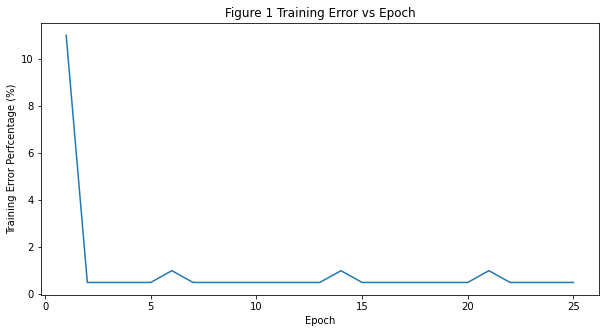

In [17]:
#Display Training Error
plotError(trainErrorFraction)

#### Batch Delta Train for 100 Epochs

Number of simulations (epochs) = 100

Learning rate (eta) = 0.0001

In [18]:
(newWeights,newTrainErrorFraction,weightUpdateCountBatch100) = batchDeltaTrain(X_mat,Y_mat,100,eta,initialWeights)



Epochs:100 and Learning Rate:0.0001
Total Training Features (including bias):3
Total Training Points:200
Initial Weights:[0.23012826 0.30256145 0.02072239]
*** Running batch perceptron train simulation for epoch 1 ***
Train Error Percentage:11.0 %
*** Running batch perceptron train simulation for epoch 2 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 3 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 4 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 5 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 6 ***
Train Error Percentage:1.0 %
*** Running batch perceptron train simulation for epoch 7 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 8 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 9 ***
Train Error Percentage:0.5 %
*** Running batch perc

##### Plotting Decision Boundary

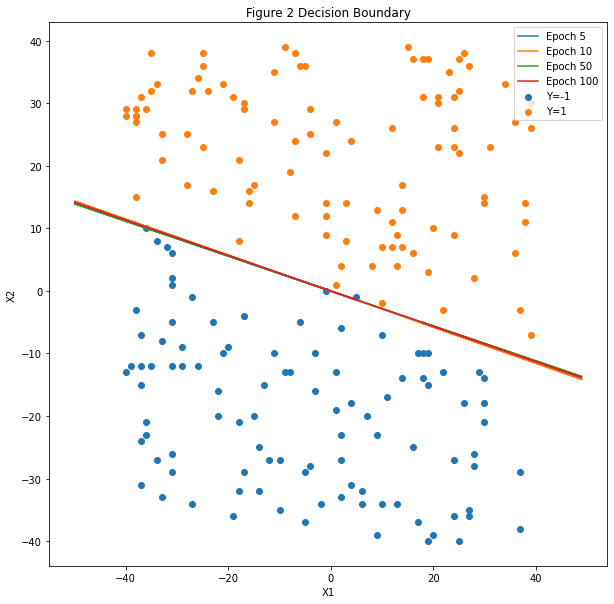

In [19]:
#Display decision boundary
plotDecisionBoundary(newWeights,X,Y)

#### Batch Delta Train for 50 Epochs

Number of simulations (epochs) = 50

In [20]:
epoch = 50

##### For Different Learning Rates: [0.1, 0.01, 0.001, 0.0001]

In [21]:
results = {'Eta-Weights':[], 'Eta-Error':[], 'WeightUpdateCount':[]}
etas = [0.1, 0.01, 0.001, 0.0001]
for eta in etas:
  (etaWeights,etaError,weightUpdateCountBatch) = batchDeltaTrain(X_mat,Y_mat,epoch,eta,initialWeights)
  results['Eta-Weights'].append(etaWeights)
  results['Eta-Error'].append(etaError)
  results['WeightUpdateCount'].append(weightUpdateCountBatch)



Epochs:50 and Learning Rate:0.1
Total Training Features (including bias):3
Total Training Points:200
Initial Weights:[0.23012826 0.30256145 0.02072239]
*** Running batch perceptron train simulation for epoch 1 ***
Train Error Percentage:11.0 %
*** Running batch perceptron train simulation for epoch 2 ***
Train Error Percentage:42.0 %
*** Running batch perceptron train simulation for epoch 3 ***
Train Error Percentage:17.0 %
*** Running batch perceptron train simulation for epoch 4 ***
Train Error Percentage:1.0 %
*** Running batch perceptron train simulation for epoch 5 ***
Train Error Percentage:1.0 %
*** Running batch perceptron train simulation for epoch 6 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 7 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 8 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 9 ***
Train Error Percentage:0.5 %
*** Running batch percep

##### Plotting Error for different Learning Rates

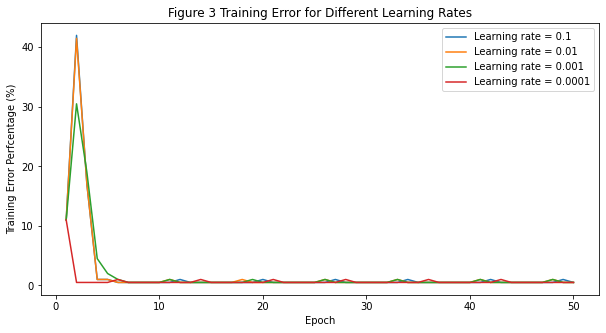

In [22]:
#Display Training Error for different Learning Rates
plotErrorLearningRate(results['Eta-Error'],etas)

### Choosing the Best Learning Rate

This section will pick the best learning rate from the simulation of 50 epochs, based on the simulation which has the minimum training error.

In [23]:
min_error_dict = {'Eta': [],'MTE': [],'Epoch': []}

print()
#Get minimum error
for eta, errors in zip(etas, results['Eta-Error']):
  min_e = min(errors)
  #Epoch of minimum
  pos = errors.index(min_e) + 1
  print(f'Learning Rate:{eta} => Minimum Training Error:{min_e}% => Epoch:{pos}')
  min_error_dict['Eta'].append(eta)
  min_error_dict['MTE'].append(min_e)
  min_error_dict['Epoch'].append(pos)

df = pd.DataFrame(min_error_dict)

min_MTE_df= df[df['MTE'] == df['MTE'].min()]
best_eta = min_MTE_df[min_MTE_df['Epoch'] == min_MTE_df['Epoch'].min()]
bestEta = best_eta.iloc[0]['Eta']
print(f'Best Learning Rate:{bestEta}')


Learning Rate:0.1 => Minimum Training Error:0.5% => Epoch:6
Learning Rate:0.01 => Minimum Training Error:0.5% => Epoch:6
Learning Rate:0.001 => Minimum Training Error:0.5% => Epoch:7
Learning Rate:0.0001 => Minimum Training Error:0.5% => Epoch:2
Best Learning Rate:0.0001


### Execution of Delta Train with the best learning rate.

#### Stochastic Delta Train

In [24]:
#Get time for stochastic
start_time_stoch = time.time()
(bestEtaWeights,bestEtaError,weightUpdateCountStoc) = stochasticDeltaTrain(X_mat,Y_mat,epoch,bestEta,initialWeights)
stoch_exec_secs = (time.time() - start_time_stoch)



Epochs:50 and Learning Rate:0.0001
Total Training Features (including bias):3
Total Training Points:200
*** Running stochastic perceptron train simulation for epoch 1 ***
Train Error Percentage:5.5 %
*** Running stochastic perceptron train simulation for epoch 2 ***
Train Error Percentage:3.0 %
*** Running stochastic perceptron train simulation for epoch 3 ***
Train Error Percentage:1.0 %
*** Running stochastic perceptron train simulation for epoch 4 ***
Train Error Percentage:1.0 %
*** Running stochastic perceptron train simulation for epoch 5 ***
Train Error Percentage:0.5 %
*** Running stochastic perceptron train simulation for epoch 6 ***
Train Error Percentage:0.5 %
*** Running stochastic perceptron train simulation for epoch 7 ***
Train Error Percentage:0.5 %
*** Running stochastic perceptron train simulation for epoch 8 ***
Train Error Percentage:0.5 %
*** Running stochastic perceptron train simulation for epoch 9 ***
Train Error Percentage:0.5 %
*** Running stochastic percept

##### Error - Plot

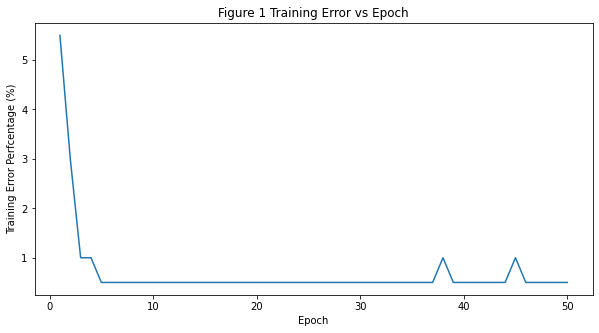

In [25]:
#Display Training Error
plotError(bestEtaError)

#### Batch Delta Train

In [26]:
#Get time for batch
start_time_batch = time.time()
(bestEtaWeights,bestEtaError,weightUpdateCountBatch) = batchDeltaTrain(X_mat,Y_mat,epoch,bestEta,initialWeights)
batch_exec_secs = (time.time() - start_time_batch)



Epochs:50 and Learning Rate:0.0001
Total Training Features (including bias):3
Total Training Points:200
Initial Weights:[0.23012826 0.30256145 0.02072239]
*** Running batch perceptron train simulation for epoch 1 ***
Train Error Percentage:11.0 %
*** Running batch perceptron train simulation for epoch 2 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 3 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 4 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 5 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 6 ***
Train Error Percentage:1.0 %
*** Running batch perceptron train simulation for epoch 7 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 8 ***
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation for epoch 9 ***
Train Error Percentage:0.5 %
*** Running batch perce

##### Error - Plot

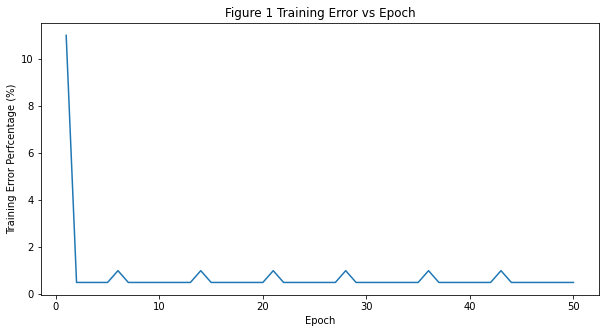

In [27]:
#Display Training Error
plotError(bestEtaError)

### Results

In [28]:
#Display results
print(f'\nEpochs: {epoch}')
print(f'Learning Rate: {bestEta}')

print(f'\nStochastic Training:')
print(f'\tExecution Time(secs): {stoch_exec_secs}')
print(f'\tNumber of Weight Updates: {weightUpdateCountStoc}')

print(f'\nBatch Training:')
print(f'\tExecution Time(secs): {batch_exec_secs}')
print(f'\tNumber of Weight Updates: {weightUpdateCountBatch}')


Epochs: 50
Learning Rate: 0.0001

Stochastic Training:
	Execution Time(secs): 0.2738814353942871
	Number of Weight Updates: 10000

Batch Training:
	Execution Time(secs): 0.05171036720275879
	Number of Weight Updates: 50


## Delta Train with a Decaying Learning Rate

#### Implementing Delta Train Rule with a decaying learning rate.

Decaying learning rate can be any value: [0,1].

For this implementation, we have taken the decay of the learning rate to be "0.8".

### Training a model with decaying learning rate.
You can modify the decay in learning rate from the following block. To change, modify the value of the variable: decay in the block.

In [29]:
#Function to run Stochastic Delta train simulation
def batchDeltaTrain_decayLearning(X_train,Y_train,epoch,eta,initialWeights, decay=1):
    weightUpdateCountBatch = 0
    #Wrong predictions
    trainFrac = 0
    #Storing original learning rate
    original_eta = eta
    #Save training error for epochs
    trainError = []
    #Weights to return
    weights = []
    print(f'\n\nEpochs:{epoch} and Learning Rate:{eta}')
    #Number of features
    n = len(X_train[0])
    print(f'Total Training Features (including bias):{n}')
    #Initialize weights
    w = initialWeights
    #Total Training data points
    m = len(X_train)
    #Total Testing data points
    print(f'Total Training Points:{m}')
    print(f'Initial Weights:{w}')
    for i in range(epoch):
        #Correctly classified
        correctPredictions = 0
        #Append weights
        weights.append(w)
        trainFrac = 0
        print(f'*** Running batch perceptron train simulation with decaying learning rate for epoch {i+1}. ***')
        print(f'Learning Rate: {eta}, Decay in Learning Rate: {decay}')
        st = 0
        loss = 0
        yt = []
        st = np.dot(X_train, w)
        for s in st:
            if s > 0:
                yt.append(1)
            else:
                yt.append(-1)
        yt = np.array(yt).reshape(200,1)
        #Check loss/error
        loss = Y_train - yt
        for loss_indiv in loss:
            if loss_indiv == 0:
                correctPredictions = correctPredictions + 1
            else:
                trainFrac = trainFrac + 1
        dt = eta * np.dot(X_train.T,loss).T[0]
        weightUpdateCountBatch = weightUpdateCountBatch + 1
        #Update weight
        w = w + dt
        #decaying learning rate
        #eta = pow(decay,i) * original_eta
        eta = eta * decay
        trainError.append((trainFrac/m)*100)
        print(f'Train Error Percentage:{trainError[-1]} %')
        #Exit on perfect classficiation for all training points
        #if correctPredictions == m:
        #   print('Stop Training - Perfect Predictions')
        #    return (weights,trainError)
    print('Stop Training - End of Epochs')
    return (weights,trainError,weightUpdateCountBatch)


In [30]:
#Function to display Training Error per Epoch
def plotError(eta,errors, labels,title):
    E = [i+1 for i in range(len(errors[0]))]
    fig,axes = plt.subplots(figsize=(10,5),num='Training Error Plot')
    axes.set_title(f'{title} Training Error vs Epoch at initial learning rate: {eta}')
    axes.set_xlabel('Epoch')
    axes.set_ylabel('Training Error Perfcentage (%)')
    for error,label in zip(errors,labels):
        axes.plot(E,error,label=label)
    plt.legend(loc='upper right')
    plt.show()

#### Simulations

This section runs a simulation for 25 epochs for both delta train and delta train with decaying learning rate, in order to compare their performance.

In [31]:
#Number of iterations
epoch = 25 
#Learning rate
decayeta = 0.8
#decay in learning rate
decay = 0.8
#Send matrix form
X_mat = X.to_numpy()
Y_mat = Y.to_numpy()
#Run batch decay delta train simulations with decaying learning rate
(simulWeightsDecay,trainErrorDecay,weightUpdateCountBatchDecay25) = batchDeltaTrain_decayLearning(X_mat,Y_mat,epoch,decayeta,initialWeights,decay)
#Run batch delta train simulations with constant learning rate
(simulWeightsNoDecay,trainErrorNoDecay,weightUpdateCountBatchNoDecay25) = batchDeltaTrain(X_mat,Y_mat,epoch,decayeta,initialWeights)



Epochs:25 and Learning Rate:0.8
Total Training Features (including bias):3
Total Training Points:200
Initial Weights:[0.23012826 0.30256145 0.02072239]
*** Running batch perceptron train simulation with decaying learning rate for epoch 1. ***
Learning Rate: 0.8, Decay in Learning Rate: 0.8
Train Error Percentage:11.0 %
*** Running batch perceptron train simulation with decaying learning rate for epoch 2. ***
Learning Rate: 0.6400000000000001, Decay in Learning Rate: 0.8
Train Error Percentage:42.0 %
*** Running batch perceptron train simulation with decaying learning rate for epoch 3. ***
Learning Rate: 0.5120000000000001, Decay in Learning Rate: 0.8
Train Error Percentage:14.000000000000002 %
*** Running batch perceptron train simulation with decaying learning rate for epoch 4. ***
Learning Rate: 0.40960000000000013, Decay in Learning Rate: 0.8
Train Error Percentage:0.5 %
*** Running batch perceptron train simulation with decaying learning rate for epoch 5. ***
Learning Rate: 0.327

#### Comparison b/w Delta Train and Delta Train with Decaying Learning Rate

##### Plotting Error

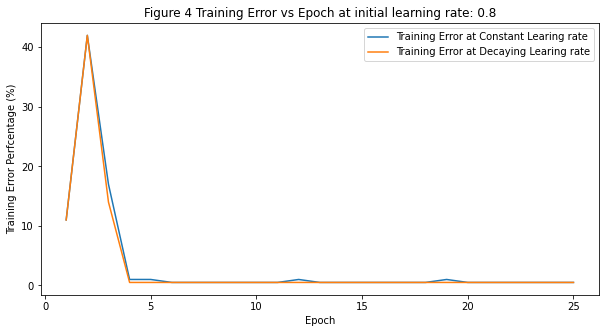

In [32]:
#Plots comparison between training error at constant rate V/s training error at decaying learning rate
plotError(decayeta,(trainErrorNoDecay, trainErrorDecay),('Training Error at Constant Learning rate','Training Error at Decaying Learning rate'),'Figure 4')

## Delta Train Rule with a Adaptive learning rate.

Threshold [t](to compare the new error with the previous error) for modifying the learning rate can be any value: [0,1].
Decay in learning rate [d] for decaying the learning rate can be any value: [0,1].
Improvement in learning rate [D] for improving the learning rate can be any value: [1,infinity).
 
For this implementation, we have taken:

t = 3 (%)

d = 0.9

D = 1.02


### Training a model with adaptive learning rate.

You can modify the hyperparameters from the following block under **Simulations**.

In [33]:
#Function to run adaptive batch Delta train simulation
def batchDeltaTrain_adaptiveLearning(X_train,Y_train,epoch,eta,initialWeights,t = 0.03, d = 0.9, D = 1.02):
    weightUpdateCountBatch = 0
    #Wrong predictions
    trainFrac = 0
    #Storing original learning rate
    original_eta = eta
    #Save training error for epochs
    trainError = []
    #Weights to return
    weights = []
    print(f'\n\nEpochs:{epoch} and Learning Rate:{eta}')
    #Number of features
    n = len(X_train[0])
    print(f'Total Training Features (including bias):{n}')
    #Initialize weights
    w = initialWeights
    #Total Training data points
    m = len(X_train)
    #Total Testing data points
    print(f'Total Training Points:{m}')
    print(f'Initial Weights:{w}')
    prev_error = 0
    for i in range(epoch):
        #Correctly classified
        correctPredictions = 0
        #Append weights
        weights.append(w)
        trainFrac = 0
        print(f'*** Running batch perceptron train simulation with adaptive learning rate for epoch {i+1}. ***')
        print(f'Learning Rate: {eta}, t : {t}, d: {d}, D: {D}')
        st = 0
        loss = 0
        yt = []
        st = np.dot(X_train, w)
        for s in st:
            if s > 0:
                yt.append(1)
            else:
                yt.append(-1)
        yt = np.array(yt).reshape(200,1)
        #Check loss/error
        loss = Y_train - yt
        for loss_indiv in loss:
            if loss_indiv == 0:
                correctPredictions = correctPredictions + 1
            else:
                trainFrac = trainFrac + 1
        curr_error = (trainFrac/m)*100
        trainError.append(curr_error)
        if i == 0:
            #Update weight
            dt = eta * np.dot(X_train.T,loss).T[0]
            w = w + dt
            weightUpdateCountBatch = weightUpdateCountBatch + 1
        if i != 0:
            if(trainError[-1] - trainError[-2] >= t):
                #decrease learning rate
                eta = d * eta
            else:
                #increase learning rate
                eta = D * eta
                #Update weight
                dt = eta * np.dot(X_train.T,loss).T[0]
                w = w + dt
                weightUpdateCountBatch = weightUpdateCountBatch + 1
        print(f'Train Error Percentage:{trainError[-1]} %')
        #Exit on perfect classficiation for all training points
        #if correctPredictions == m:
        #   print('Stop Training - Perfect Predictions')
        #    return (weights,trainError)
    print('Stop Training - End of Epochs')
    #print(weights)
    return (weights,trainError,weightUpdateCountBatch)


#### Simulations

This section runs a simulation for 25 epochs for both delta train and delta train with adaptive learning rate, in order to compare their performance.

In [34]:
#Number of simulations
epoch = 25 
#Learning rate
adapteta = 0.5
#Initializing hyper-paramters
t = 3 #%
d = 0.9
D = 1.02
#Send matrix form
X_mat = X.to_numpy()
Y_mat = Y.to_numpy()
#Run batch daptive delta train simulations with adaptive learning.
(simulWeightsAdapt,trainErrorAdapt,weightUpdateCountBatchAdapt25) = batchDeltaTrain_adaptiveLearning(X_mat,Y_mat,epoch,adapteta,initialWeights,t,d,D)
#Run batch delta train simulations with constant learning rate
(simulWeightsNoAdapt,trainErrorNoAdapt,weightUpdateCountBatchNoAdapt25) = batchDeltaTrain(X_mat,Y_mat,epoch,adapteta,initialWeights)



Epochs:25 and Learning Rate:0.5
Total Training Features (including bias):3
Total Training Points:200
Initial Weights:[0.23012826 0.30256145 0.02072239]
*** Running batch perceptron train simulation with adaptive learning rate for epoch 1. ***
Learning Rate: 0.5, t : 3, d: 0.9, D: 1.02
Train Error Percentage:11.0 %
*** Running batch perceptron train simulation with adaptive learning rate for epoch 2. ***
Learning Rate: 0.5, t : 3, d: 0.9, D: 1.02
Train Error Percentage:42.0 %
*** Running batch perceptron train simulation with adaptive learning rate for epoch 3. ***
Learning Rate: 0.45, t : 3, d: 0.9, D: 1.02
Train Error Percentage:42.0 %
*** Running batch perceptron train simulation with adaptive learning rate for epoch 4. ***
Learning Rate: 0.459, t : 3, d: 0.9, D: 1.02
Train Error Percentage:16.5 %
*** Running batch perceptron train simulation with adaptive learning rate for epoch 5. ***
Learning Rate: 0.46818000000000004, t : 3, d: 0.9, D: 1.02
Train Error Percentage:1.0 %
*** Runn

#### Comparison b/w Delta Train and Delta Train with Adaptive Learning Rate

##### Plotting Error

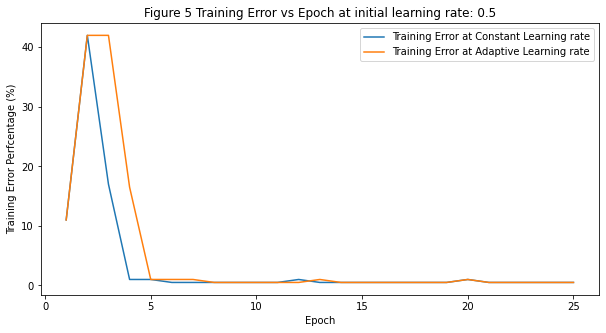

In [35]:
plotError(adapteta,(trainErrorNoAdapt, trainErrorAdapt),('Training Error at Constant Learning rate','Training Error at Adaptive Learning rate'),'Figure 5')

## Conclusion

1. **Delta Train**:

  > a. *Stochastic Delta Train*: The training error reduces a bit slower than Batch Delta Train. But, The training error once converged remains constant and shows less erratic pattern in error.

  > b. *Batch Delta Train*: The training error reduces very fast. But, after every few epochs there is a spike seen which dies down again in a few.

2. **Delta Train with Decaying Learning Rate**:

  In comparison to Batch Delta Train, this simulation reduces the training error a bit slower. But, remains more constant.

3. **Delta Train with Adaptive Learning Rate**:

  In comparison to Batch Delta Train, this simulation takes longer to reduce the training error, perhaps a epoch more. It then follows the Batch Delta Train with a shifted pattern by an epoch or two.



